In [ ]:
#combine all variables on one figure

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import skbio
from collections import Counter
from statsmodels.formula.api import ols
import researchpy as rp

In [2]:
promoterpref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoterpref}_czechowski_constitutive_variable_random.txt'
window_bed = f'../../../data/output/{file_names}/rolling_window/{promoterpref}_windows.bed'
EPD_TSS_bed = f'../../../data/EPD_promoter_analysis/EPDnew_promoters/At_EPDnew.bed'
promoter_bed = f'../../../data/output/{file_names}/FIMO/{promoterpref}.bed' 
promoter_no_5UTR = f'../../../data/output/{file_names}/promoters.gff3'#to extract the Araport11 TSSs
foldername_prefix = 'all_combined_rw'

In [3]:
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw/{promoterpref}_GCcontent_rw.tsv'

In [4]:
TF_diversity_bed = f'../../../data/output/{file_names}/rolling_window/TF_diversity_rw/{promoterpref}_TF_diversity.bed'

In [5]:
#bp_covered = '../../data/promoter_analysis/promoters.bp_covered.txt'
bp_covered = f'../../../data/output/{file_names}/rolling_window/TFBS_coverage_rw/{promoterpref}_bpcovered_rw.bed'


In [6]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoterpref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoterpref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoterpref}_rootshootintersect_bpcovered_rw.bed'

In [7]:
#make directory for the plots to be exported to
dirName = f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/all_combined_rw/  already exists


In [8]:
#make directory for the plots to be exported to
dirName = f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/all_combined_rw/plots  already exists


In [9]:
#sort GC content input files
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
#make df columns integars
GC_content = GC_content.astype({'stop':'int','start':'int','chr':'int'})
#add window length column
GC_content = GC_content.assign(window_length=GC_content.stop - GC_content.start)
#drop name column
GC_content.drop(['name'], axis=1, inplace=True)

# #merge to limit to genes of interest
# GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
# GC_content

In [10]:
#Read in TF_diversity_bed
TF_diversity = pd.read_table(TF_diversity_bed, sep='\t', header=0)
#Read in windows_bed
windows_df = pd.read_table(window_bed, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name']
windows_df.columns = cols
#merge windows bed with TF_diversity
TF_diversity = pd.merge(windows_df,TF_diversity, how='left', on='name')
#turn NaN into 0s
TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']] = TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']].fillna(0)
#Make AGI column
TF_diversity['AGI'] = TF_diversity.name.str.split('_',expand=True)[0]
#make window number column
TF_diversity['window_number'] = TF_diversity.name.str.split('_',expand=True)[1]
#make df columns integars
TF_diversity = TF_diversity.astype({'stop':'int','start':'int','chr':'int','Shannon_diversity_TF':'int','Shannon_diversity_TF_family':'int', 'unique_TF_count':'int', 'total_TF_count':'int','TF_family_count':'int'})
#add window length column
TF_diversity = TF_diversity.assign(window_length=TF_diversity.stop - TF_diversity.start)
#drop name column
TF_diversity.drop(['name'], axis=1,inplace=True)

In [11]:
#read in coverage bedfile
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100
#Add AGI and window_number column to coverage_df
coverage_df = coverage_df.assign(AGI=coverage_df.name.str.extract(r'(.*?)\_'))
coverage_df['window_number'] = coverage_df.name.str.split('_', n=2, expand = True)[1]
#coverage_df = coverage_df.assign(window_number=coverage_df.name.str[-1:])
#drop name column
coverage_df.drop(['name'], axis=1,inplace=True)

In [12]:
## merge all of the dfs on AGI, window number, chr, start and stop
# merge GC content with TF diversity df
all_combined = pd.merge(GC_content, TF_diversity, on = ['chr','start','stop','AGI','window_number','window_length'])
# merge this with TFBS coverage df
all_combined = pd.merge(all_combined, coverage_df, on = ['chr','start','stop','AGI','window_number','window_length'])
#drop fraction_bases_covered and no._of_bases_covered
all_combined.drop(['no._of_bases_covered', 'fraction_bases_covered'], axis=1, inplace = True)

In [13]:
all_combined

,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,no._of_overlaps,percentage_bases_covered
0,39.0,AT1G01010,21,1,2659,2759,100,0,0,0,0,0,0,0.0
1,36.0,AT1G01010,20,1,2709,2809,100,0,0,0,0,0,0,0.0
2,36.0,AT1G01010,19,1,2759,2859,100,0,0,0,0,0,0,0.0
3,34.0,AT1G01010,18,1,2809,2909,100,0,0,0,0,0,0,0.0
4,37.0,AT1G01010,17,1,2859,2959,100,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356193,37.0,AT5G67640,17,5,26971348,26971448,100,0,0,0,0,0,0,0.0
356194,38.0,AT5G67640,18,5,26971398,26971498,100,0,0,0,0,0,0,0.0
356195,38.0,AT5G67640,19,5,26971448,26971548,100,1,0,2,2,1,2,15.0
356196,40.0,AT5G67640,20,5,26971498,26971598,100,1,0,2,2,1,2,24.0


In [14]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("ticks")

In [15]:
#remove windows with fewer than 100 promoters extending to that location
all_combined = all_combined[all_combined['window_number'].map(all_combined['window_number'].value_counts()) > 99]

In [16]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [17]:
def rep_sample(df, col, n, random_state):
    """function to return a df with equal sample sizes
    taken from here: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe"""
    #identify number of categories
    nu = df[col].nunique()
    # find number of rows
    m = len(df)
    # integar divide total sample size by number of categories
    mpb = n // nu
    # multiply this by the number of categories and subtract from the number of samples to find the remainder
    mku = n - mpb * nu
    # make an array fileld with zeros corresponding to each category
    fills = np.zeros(nu)

    # make values in the array 1s up until the remainder
    fills[:mku] = 1

    # calculate sample sizes for each category
    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)

    #group the df by categories
    gb = df.groupby(col)
    #define sample size function
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], random_state = random_state)
    #run sample size function on each category
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    #return concatenated sub dfs
    return pd.concat(subs)

In [18]:
def windows_coords(output_prefix,all_combined_df,
                   variable_of_interest1,variable_of_interest1_name,
                   variable_of_interest2,variable_of_interest2_name,
                   variable_of_interest3,variable_of_interest3_name,
                   promoter_bed,promoter_no_5UTR,
                   window_offset,EPD_TSS_bed,includeEPDTSS=False,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='median',ci=95, n_boot=10000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot."""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start  
    #merge promoter_bed with all_combined_df on AGI
    merged = pd.merge(all_combined_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))

    #remove NaN for all variables of interest
    merged = merged[merged[variable_of_interest1].notnull()]
    merged = merged[merged[variable_of_interest2].notnull()]
    merged = merged[merged[variable_of_interest3].notnull()]

    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    #merged with windows    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]
    #Get most common transcript TSS location from eukaryotic promoter database (last modified on EPD 06/06/2018)
    #Note - not all promoters have a TSS on EPD
    if includeEPDTSS==True:
        EPD_TSS_df = pd.read_table(EPD_TSS_bed, delim_whitespace=True, header=None, skiprows=4)
        cols = ['chr','start','stop','transcript_EPD','score_EPD','strand_EPD','thickstart_EPD','thickend_EPD']
        EPD_TSS_df.columns = cols
        #add AGI column
        EPD_TSS_df['AGI'] = EPD_TSS_df.transcript_EPD.str.split('_',expand=True)[0]
        #add TSS location column
        EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'thickstart_EPD']
        EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'thickend_EPD'] -1
        #merged with windows
        merged2 = pd.merge(merged2,EPD_TSS_df, on='AGI', how='left', suffixes=('','_EPD'))

        #remove NaN (promoters in EPD but not in promoters_5UTR)

        merged2 = merged2[merged2.length.notnull()] 
        
        #transfrom EPD TSS column in the same way as the position column
        merged2.loc[merged2.strand == '-', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '-', 'TSS_EPD'] - merged2.loc[merged2.strand == '-','start_wholeprom']
        merged2.loc[merged2.strand == '+', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS_EPD']
        #make integars
        merged2 = merged2.astype({'TSS_transformed_EPD':'float64'})
        
    #calculate longest promoter length based on window cutoff
    number_of_windows = len(all_combined_df.window_number.unique())
    window_length = all_combined_df.window_length.max()    
    length_of_longest_promoter = number_of_windows*(window_length-window_offset)

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add Araport TSS location column
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']
    
    #make integars
    merged2 = merged2.astype({'start_no_UTR':'float64','stop_no_UTR':'float64',
                              'TSS':'float64','TSS_transformed_Araport11':'float64',f'{variable_of_interest1}':'float64',f'{variable_of_interest2}':'float64',f'{variable_of_interest3}':'float64',f'{chromatin_tissue_variable}':'float64'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]



    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 5
   
    
    
    
    
    
    #make subplots
    if includeEPDTSS == True:
        subplots = subplots + 1
        f, axes = plt.subplots(subplots, figsize=(10,16))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        EPDTSSplot = axes[subplots-(subplots-2)]   
        #promlengthsplot = axes[subplots-(subplots-3)]
        variableofinterest1plot = axes[subplots-(subplots-3)]
        variableofinterest2plot = axes[subplots-(subplots-4)]
        variableofinterest3plot = axes[subplots-(subplots-5)]
    else:
        f, axes = plt.subplots(subplots, figsize=(10,13))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        #promlengthsplot = axes[subplots-(subplots-2)]
        variableofinterest1plot = axes[subplots-(subplots-2)]
        variableofinterest2plot = axes[subplots-(subplots-3)]
        variableofinterest3plot = axes[subplots-(subplots-4)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None
    try:
        Araport11TSSplot
    except NameError:
        Araport11TSSplot = None
    try:
        EPDTSSplot
    except NameError:
        EPDTSSplot = None
#     try:
#         promlengthsplot
#     except NameError:
#         promlengthsplot = None
    try:
        variableofinterest1plot
    except NameError:
        variableofinterest1plot = None
        
    try:
        variableofinterest2plot
    except NameError:
        variableofinterest2plot = None
        
    try:
        variableofinterest3plot
    except NameError:
        variableofinterest3plot = None
        
    #If EPD TSS plot is present, filter promoters which aren't in EPD to remove NaNs
    if EPDTSSplot != None:
        #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
        merged2 = merged2[merged2.TSS_transformed_EPD.notnull()]
    
    
    if genetype!=False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #remove windows with fewer than 50 promoters extending to that location if looking at specific genetypes
        merged2 = merged2[merged2['window_number'].map(merged2['window_number'].value_counts()) > 49]
        #redefine longest promoter length based on window cutoff
        number_of_windows = len(merged2.window_number.unique())
        window_length = merged2.window_length.max()    
        length_of_longest_promoter = number_of_windows*(window_length-window_offset)
    
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    if includeEPDTSS==True:
        merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']] = -merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']]
    else:
        merged2[['length','TSS_transformed_Araport11','position']] = -merged2[['length','TSS_transformed_Araport11','position']]
        
        
    if genetype==False:
        
        #length_of_longest_promoter = merged_positive.length.max()
        #if openchromplot variable present, add that plot
        #next plot letter name
        nextletter = 'A'

        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #AraportTSS distribution
            sns.distplot(merged2.TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'{nextletter}: All promoters Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPDTSS distribution
            sns.distplot(merged2.TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'{nextletter}: All promoters EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
    
        

        
        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest1], x=merged2.position, ax=variableofinterest1plot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest1plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest2], x=merged2.position, ax=variableofinterest2plot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest2plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if variableofinterestplot variable present, add that plot
        if variableofinterest3plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest3], x=merged2.position, ax=variableofinterest3plot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest3plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position upstream of ATG')
    
    
    
               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #next plot letter name
        nextletter = 'A'
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: {genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'{nextletter}: {genetype} Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'{nextletter}: EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
     
        

        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], 
                         x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest1plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest1plot.set_title(f'{nextletter}: {genetype} {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], 
                         x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest2plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest2plot.set_title(f'{nextletter}: {genetype} {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if variableofinterest3plot variable present, add that plot
        if variableofinterest3plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], 
                         x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest3plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest3plot.set_title(f'{nextletter}: {genetype} {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position upstream of ATG')
            
        
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #variableofinterestplot.set_ylim([0,merged2.groupby('window_number')[variable_of_interest].median().max()+20])
        #set x axis range if specified 
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range
        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])        
#         f.tight_layout()
        
    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]

        ## make a subselection of categories so all sample sizes are equal
        # first select only the relevant genetypes
        merged2 = merged2[merged2.gene_type.isin([genetype,genetype2])]
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]


        #if openchromplot variable present, add that plot
        #add plot letter name
        nextletter = 'A'
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            #set titles & axes names
            OpenChromplot.set_title(f'{nextletter}: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            #set titles & axes names
            Araport11TSSplot.set_title(f'{nextletter}: Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            #set titles & axes names
            EPDTSSplot.set_title(f'{nextletter}: EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if promlengthsplot variable present, add that plot
        

        
        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], x=merged2[merged2.gene_type == genetype].position,
                            ax=variableofinterest1plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest1], x=merged2[merged2.gene_type == genetype2].position,
                            ax=variableofinterest1plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest1plot.set_title(f'{nextletter}: {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
            
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], x=merged2[merged2.gene_type == genetype].position,
                            ax=variableofinterest2plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest2], x=merged2[merged2.gene_type == genetype2].position,
                            ax=variableofinterest2plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest2plot.set_title(f'{nextletter}: {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
            
        #if variableofinterest3plot variable present, add that plot
        if variableofinterest3plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], x=merged2[merged2.gene_type == genetype].position,
                            ax=variableofinterest3plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest3], x=merged2[merged2.gene_type == genetype2].position,
                            ax=variableofinterest3plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest3plot.set_title(f'{nextletter}: {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position upstream of ATG')
        
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#         f.tight_layout()
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal    
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        #add plot letter name
        nextletter = 'A'
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])   
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype3)
            #set titles & axes names
            Araport11TSSplot.set_title(f'Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype3)
            #set titles & axes names
            EPDTSSplot.set_title(f'EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        


        
        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest1plot,
                            label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest1], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterest1plot,
                            label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest1], x=merged2[merged2.gene_type == genetype3].position, ax=variableofinterest1plot,
                            label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest1plot.set_title(f'{variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
            
            
            
            
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest2plot,
                            label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest2], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterest2plot,
                            label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest2], x=merged2[merged2.gene_type == genetype3].position, ax=variableofinterest2plot,
                            label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest2plot.set_title(f'{variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if variableofinterest3plot variable present, add that plot
        if variableofinterest3plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterest3plot,
                            label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest3], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterest3plot,
                            label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest3], x=merged2[merged2.gene_type == genetype3].position, ax=variableofinterest3plot,
                            label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest3plot.set_title(f'{variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position upstream of ATG')
            
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
        #set x axis length
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#             leg = n.legend()
#         f.tight_layout()
    #set x axis range if specified    
    if x_range==False:
        pass
    else:
        length_of_longest_promoter = x_range
        
    #for all subplots:
    
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim([(-length_of_longest_promoter-50),0])
    #set a tight layout
    f.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/plots/{output_prefix}_{foldername_prefix}_{estimator}_sliding_window.pdf', format='pdf')    
    return merged2

In [19]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [20]:
def plot_length(df,output_prefix, genetype=False, genetype2=False, genetype3=False):
    """function to plot length distribution of promoter"""
    #make lengths positive by squaring and then square rooting
    df.length = (df.length**2)**(1/2)
    
    if genetype==False:
        dist_plot = df['length']
        #create figure with no transparency
        dist_plot_fig = sns.distplot(dist_plot,axlabel='length (bp)').get_figure()

    elif genetype2==False:
        sns.distplot(df[df.gene_type == genetype].length, label=genetype,axlabel='length (bp)')
        
    elif genetype3==False:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2,axlabel='length (bp)').get_figure()
        plt.legend()
    else:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].length,hist=None,label=genetype3,axlabel='length (bp)')
       # plt.axlabel='length (bp)'
        plt.legend()
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/plots/{output_prefix}_promoter_lengths.pdf', format='pdf')

In [21]:
#add root chromatin coverage data
all_combined = add_coverage(all_combined, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
all_combined = add_coverage(all_combined, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
all_combined = add_coverage(all_combined, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

In [22]:
all_combined

,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,no._of_overlaps,percentage_bases_covered,name,percentage_bases_covered_root_chrom,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,39.0,AT1G01010,21,1,2659,2759,100,0,0,0,0,0,0,0.0,AT1G01010_21,100.0,AT1G01010_21,100.0,AT1G01010_21,100.0
1,36.0,AT1G01010,20,1,2709,2809,100,0,0,0,0,0,0,0.0,AT1G01010_20,100.0,AT1G01010_20,100.0,AT1G01010_20,100.0
2,36.0,AT1G01010,19,1,2759,2859,100,0,0,0,0,0,0,0.0,AT1G01010_19,100.0,AT1G01010_19,100.0,AT1G01010_19,100.0
3,34.0,AT1G01010,18,1,2809,2909,100,0,0,0,0,0,0,0.0,AT1G01010_18,100.0,AT1G01010_18,100.0,AT1G01010_18,100.0
4,37.0,AT1G01010,17,1,2859,2959,100,0,0,0,0,0,0,0.0,AT1G01010_17,100.0,AT1G01010_17,97.0,AT1G01010_17,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358595,37.0,AT5G67640,17,5,26971348,26971448,100,0,0,0,0,0,0,0.0,AT5G67640_17,44.0,AT5G67640_17,5.0,AT5G67640_17,5.0
358596,38.0,AT5G67640,18,5,26971398,26971498,100,0,0,0,0,0,0,0.0,AT5G67640_18,0.0,AT5G67640_18,0.0,AT5G67640_18,0.0
358597,38.0,AT5G67640,19,5,26971448,26971548,100,1,0,2,2,1,2,15.0,AT5G67640_19,0.0,AT5G67640_19,0.0,AT5G67640_19,0.0
358598,40.0,AT5G67640,20,5,26971498,26971598,100,1,0,2,2,1,2,24.0,AT5G67640_20,0.0,AT5G67640_20,0.0,AT5G67640_20,0.0


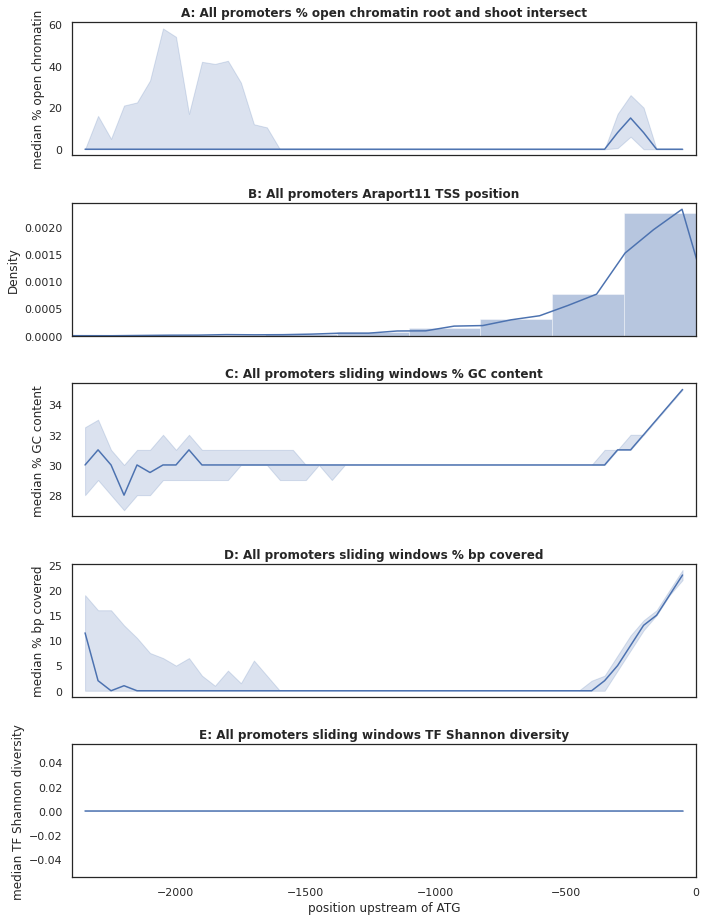

In [23]:
#all promoters in genome - median
all_proms = windows_coords('all_proms',all_combined,'percentage_GC_content','% GC content',
                           'percentage_bases_covered','% bp covered',
                           'Shannon_diversity_TF','TF Shannon diversity',
                           promoter_bed,promoter_no_5UTR,50,EPD_TSS_bed,estimator='median')

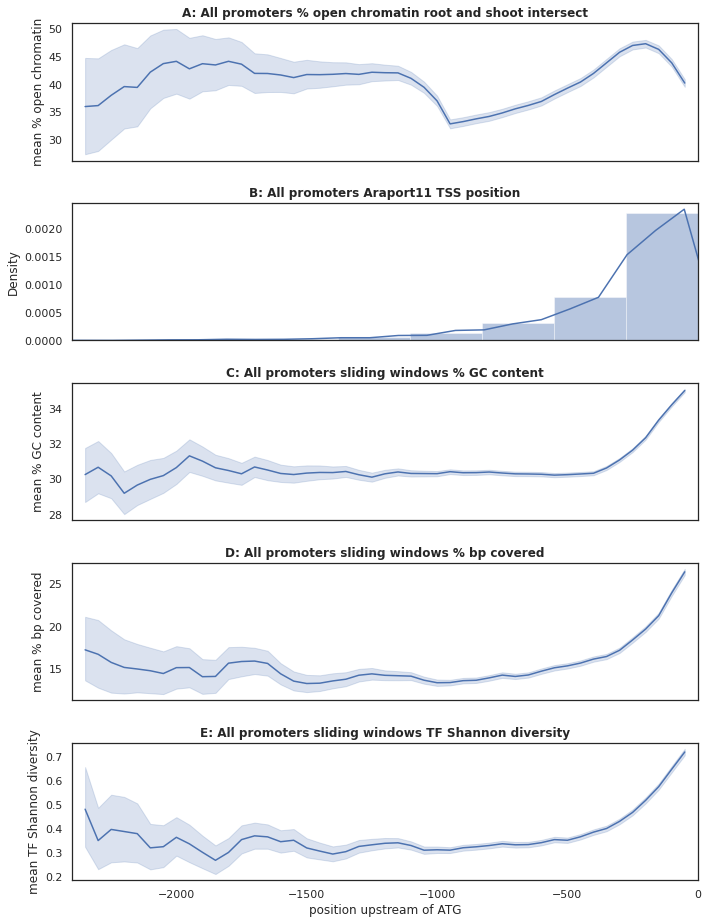

In [24]:
#all promoters in genome - mean
all_proms = windows_coords('all_proms',all_combined,'percentage_GC_content','% GC content',
                           'percentage_bases_covered','% bp covered',
                           'Shannon_diversity_TF','TF Shannon diversity',
                           promoter_bed,promoter_no_5UTR,50,EPD_TSS_bed,estimator='mean')

In [25]:
all_proms

,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,...,source_no_UTR,type_no_UTR,start_no_UTR,stop_no_UTR,dot1_no_UTR,strand_no_UTR,dot2_no_UTR,attributes_no_UTR,TSS,TSS_transformed_Araport11
0,39.0,AT1G01010,21,1,2659,2759,100,0.0,0,0,...,araport11,promoter,2630.0,3630.0,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...,3630.0,-129.0
1,36.0,AT1G01010,20,1,2709,2809,100,0.0,0,0,...,araport11,promoter,2630.0,3630.0,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...,3630.0,-129.0
2,36.0,AT1G01010,19,1,2759,2859,100,0.0,0,0,...,araport11,promoter,2630.0,3630.0,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...,3630.0,-129.0
3,34.0,AT1G01010,18,1,2809,2909,100,0.0,0,0,...,araport11,promoter,2630.0,3630.0,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...,3630.0,-129.0
4,37.0,AT1G01010,17,1,2859,2959,100,0.0,0,0,...,araport11,promoter,2630.0,3630.0,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...,3630.0,-129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358595,37.0,AT5G67640,17,5,26971348,26971448,100,0.0,0,0,...,araport11,promoter,26970668.0,26971668.0,.,-,.,ID=gene:AT5G67640;biotype=protein_coding;descr...,26970667.0,-119.0
358596,38.0,AT5G67640,18,5,26971398,26971498,100,0.0,0,0,...,araport11,promoter,26970668.0,26971668.0,.,-,.,ID=gene:AT5G67640;biotype=protein_coding;descr...,26970667.0,-119.0
358597,38.0,AT5G67640,19,5,26971448,26971548,100,1.0,0,2,...,araport11,promoter,26970668.0,26971668.0,.,-,.,ID=gene:AT5G67640;biotype=protein_coding;descr...,26970667.0,-119.0
358598,40.0,AT5G67640,20,5,26971498,26971598,100,1.0,0,2,...,araport11,promoter,26970668.0,26971668.0,.,-,.,ID=gene:AT5G67640;biotype=protein_coding;descr...,26970667.0,-119.0


## Now do constitutive and variable promoter from Czechowski et al 2005

In [26]:
#add gene type column to all_combined df
all_combined_genetype = add_genetype(all_combined, Czechowski_gene_categories)

In [27]:
#make sample sizes equal
# select only unique promoters
unique_proms = all_combined_genetype.drop_duplicates('AGI')
# next count count number of unique promoters in each gene_type
unique_proms

,AGI,gene_type,percentage_GC_content,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,...,total_TF_count,TF_family_count,no._of_overlaps,percentage_bases_covered,name,percentage_bases_covered_root_chrom,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT4G34270,constitutive,48.0,1,4,16406153,16406253,100,0,0,...,0,0,0,0.0,AT4G34270_1,100.0,AT4G34270_1,100.0,AT4G34270_1,100.0
14,AT4G33380,constitutive,45.0,12,4,16071413,16071513,100,0,0,...,6,1,6,26.0,AT4G33380_12,0.0,AT4G33380_12,0.0,AT4G33380_12,0.0
26,AT2G28390,constitutive,40.0,1,2,12143375,12143475,100,1,1,...,2,2,2,24.0,AT2G28390_1,100.0,AT2G28390_1,100.0,AT2G28390_1,100.0
50,AT1G71820,constitutive,22.0,28,1,27008571,27008671,100,0,0,...,0,0,0,0.0,AT1G71820_28,0.0,AT1G71820_28,0.0,AT1G71820_28,0.0
78,AT1G48900,constitutive,42.0,1,1,18087743,18087843,100,0,0,...,2,1,2,22.0,AT1G48900_1,100.0,AT1G48900_1,100.0,AT1G48900_1,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5939,AT3G50070,control,39.0,1,3,18566669,18566769,100,1,0,...,32,2,46,25.0,AT3G50070_1,100.0,AT3G50070_1,100.0,AT3G50070_1,100.0
5961,AT1G11130,control,25.0,27,1,3721734,3721834,100,0,0,...,0,0,1,8.0,AT1G11130_27,100.0,AT1G11130_27,34.0,AT1G11130_27,34.0
5988,AT3G12620,control,31.0,1,3,4010993,4011093,100,0,0,...,4,2,4,42.0,AT3G12620_1,0.0,AT3G12620_1,0.0,AT3G12620_1,0.0
6009,AT3G03090,control,46.0,1,3,704579,704679,100,0,0,...,1,1,1,15.0,AT3G03090_1,100.0,AT3G03090_1,0.0,AT3G03090_1,0.0


sample size in each category = 100


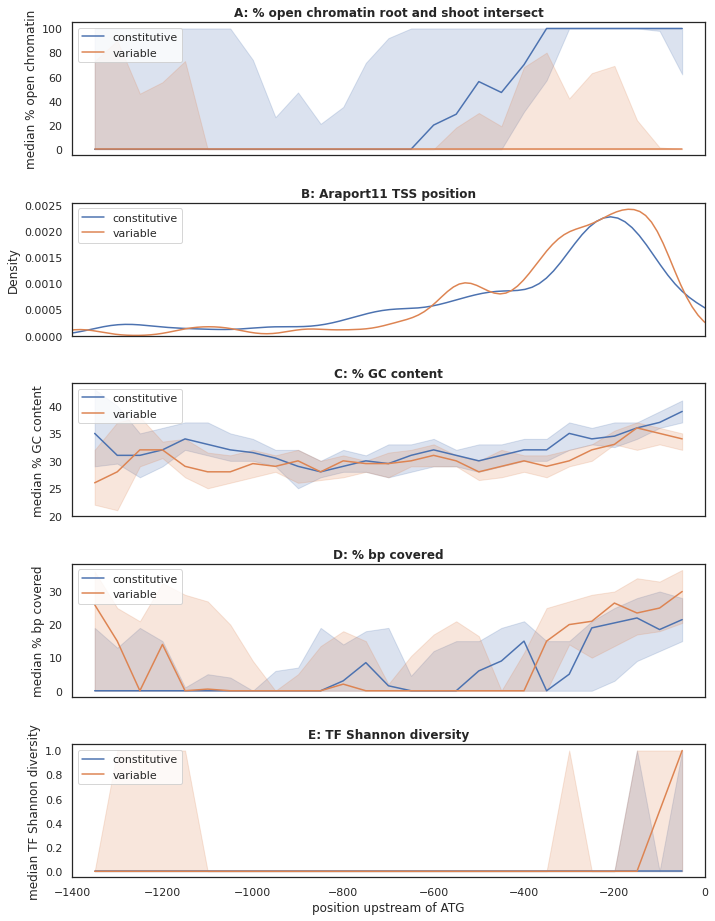

In [28]:
#plot median
rolling_rootshootintersect = windows_coords('Czechowski_genetypenocontrol',all_combined_genetype,'percentage_GC_content','% GC content',
                                            'percentage_bases_covered','% bp covered',
                                            'Shannon_diversity_TF','TF Shannon diversity',
                                            promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,includeEPDTSS=False,estimator='median',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

In [29]:
rolling_rootshootintersect

,AGI,gene_type,percentage_GC_content,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,...,source_no_UTR,type_no_UTR,start_no_UTR,stop_no_UTR,dot1_no_UTR,strand_no_UTR,dot2_no_UTR,attributes_no_UTR,TSS,TSS_transformed_Araport11
0,AT4G33380,constitutive,45.0,12,4,16071413,16071513,100,0.0,0,...,araport11,promoter,16071405.0,16071739.0,.,+,.,ID=gene:AT4G33380;biotype=protein_coding;descr...,16071739.0,-324.0
1,AT4G33380,constitutive,47.0,11,4,16071463,16071563,100,0.0,0,...,araport11,promoter,16071405.0,16071739.0,.,+,.,ID=gene:AT4G33380;biotype=protein_coding;descr...,16071739.0,-324.0
2,AT4G33380,constitutive,37.0,10,4,16071513,16071613,100,2.0,1,...,araport11,promoter,16071405.0,16071739.0,.,+,.,ID=gene:AT4G33380;biotype=protein_coding;descr...,16071739.0,-324.0
3,AT4G33380,constitutive,29.0,9,4,16071563,16071663,100,2.0,1,...,araport11,promoter,16071405.0,16071739.0,.,+,.,ID=gene:AT4G33380;biotype=protein_coding;descr...,16071739.0,-324.0
4,AT4G33380,constitutive,28.0,8,4,16071613,16071713,100,0.0,0,...,araport11,promoter,16071405.0,16071739.0,.,+,.,ID=gene:AT4G33380;biotype=protein_coding;descr...,16071739.0,-324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,AT3G18810,variable,33.0,4,3,6483743,6483843,100,0.0,0,...,araport11,promoter,6483774.0,6484067.0,.,-,.,ID=gene:AT3G18810;Name=PERK6;biotype=protein_c...,6483773.0,-180.0
4959,AT3G18810,variable,28.0,5,3,6483793,6483893,100,1.0,1,...,araport11,promoter,6483774.0,6484067.0,.,-,.,ID=gene:AT3G18810;Name=PERK6;biotype=protein_c...,6483773.0,-180.0
4960,AT3G18810,variable,23.0,6,3,6483843,6483943,100,1.0,1,...,araport11,promoter,6483774.0,6484067.0,.,-,.,ID=gene:AT3G18810;Name=PERK6;biotype=protein_c...,6483773.0,-180.0
4961,AT3G18810,variable,36.0,7,3,6483893,6483993,100,1.0,1,...,araport11,promoter,6483774.0,6484067.0,.,-,.,ID=gene:AT3G18810;Name=PERK6;biotype=protein_c...,6483773.0,-180.0


## There aren't 100 constitutive and 100 variale genes because some were filtered out if they only contained 5'UTRs as the promoter was overlapping other genes

sample size in each category = 100


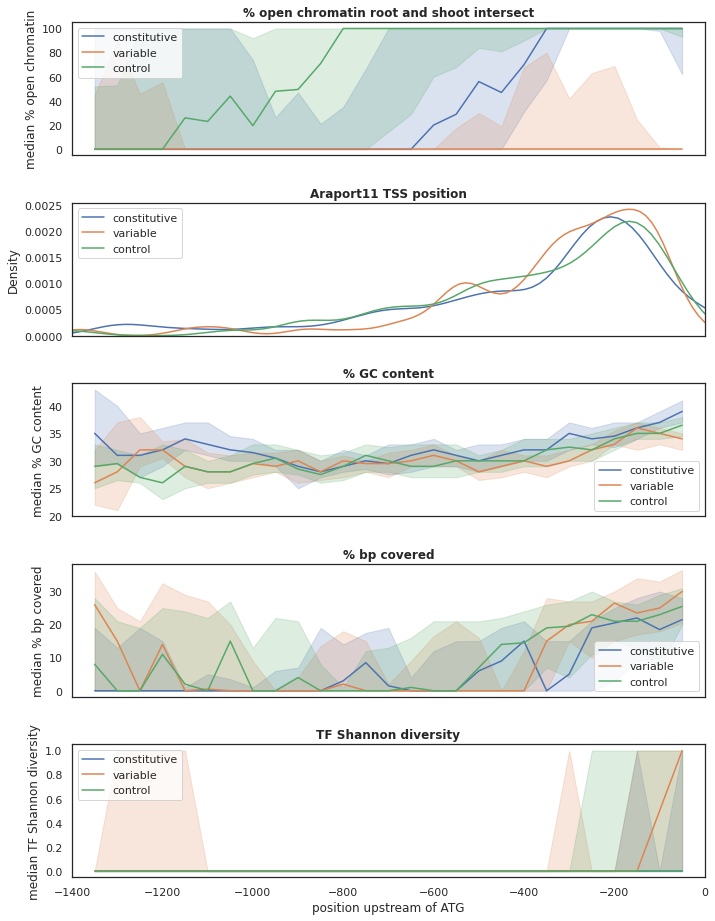

In [30]:
#plot with control genetype too
rolling_incl_control = windows_coords('Czechowski_genetype',all_combined_genetype,'percentage_GC_content','% GC content',
                                      'percentage_bases_covered','% bp covered',
                                      'Shannon_diversity_TF','TF Shannon diversity',
                                      promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,includeEPDTSS=False,estimator='median',
                                      genetype='constitutive', genetype2='variable', genetype3='control')

## plot lengths

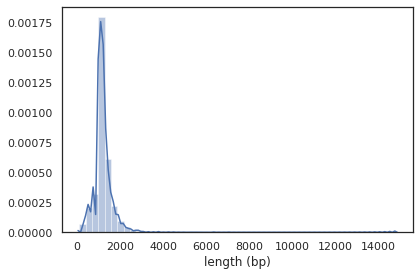

In [31]:
# plot CRM (cis-regulatory module) length distribution
plot_length(all_proms,'allproms', genetype=False)

In [32]:
#add genetype column
all_combined_types_length = add_genetype(all_proms, Czechowski_gene_categories)

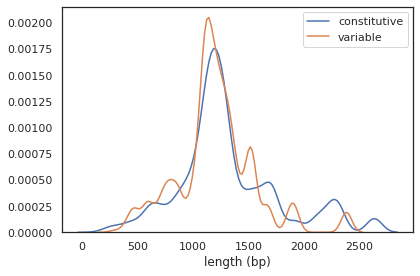

In [33]:
# plot CRM lenght distribution for each genetype excluding control genes
plot_length(all_combined_types_length,'Czechowski_genetypenocontrol', genetype='constitutive', genetype2='variable')

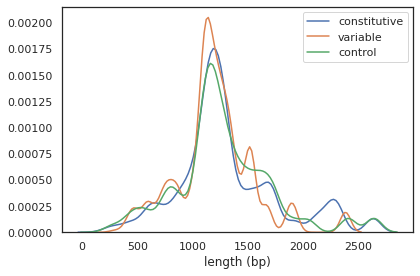

In [34]:
# plot CRM lenght distribution for each genetype including control genes
plot_length(all_combined_types_length,'Czechowski_genetype', genetype='constitutive', genetype2='variable', genetype3='control')